In [418]:
import os, sys
from six.moves import cPickle
import numpy as np

from keras.datasets.cifar10 import load_data as load_cifar10

from sklearn import manifold

from scipy.stats import multinomial as mn
from scipy.misc import imsave

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [270]:
def load_cifar10_plus_h(type='aggregate', 
    path='../data/cifar10h/'):

    """
       Type is 'aggregate' (probabilities) or 'sparse' 
       (individual choices).

       Returns the image data, original labels, and
       human "labels".

    """

    # load normal cifar10 data
    (X_train, y_train), (X_test, y_test) = load_cifar10()

    if type == 'aggregate':
        y_agg = load_cifar10h_labels(type=type, path=path)
        return X_train, y_train, X_test, y_test, y_agg

    elif type == 'sparse':
        y_sparse, X_sparse_idx = \
            load_cifar10h_labels(type=type, path=path)
        return X_train, y_train, X_test, y_test, \
               y_sparse, X_sparse_idx
    
def load_cifar10h_labels(type='aggregate', 
    path='../data/cifar10h/'):

    """
       Type is 'aggregate' (probabilities) or 'sparse' 
       (individual choices).

    """

    if type == 'aggregate':
        f_path = os.path.join(path, 'aggregate')

        with open(f_path, 'rb') as f: # straight from keras
            if sys.version_info < (3,):
                d = cPickle.load(f)
            else:
                d = cPickle.load(f, encoding='bytes')
                # decode utf8
                d_decoded = {}
                for k, v in d.items():
                    d_decoded[k.decode('utf8')] = v
                d = d_decoded

        labels = d['labels']
        return labels
    
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [358]:
print(y_agg[0])
c = 5
y_ = np.exp(y_agg[0]*c) / np.sum(np.exp(y_agg[0]*c))
print(y_)

[0.         0.01960784 0.01960784 0.94117647 0.         0.01960784
 0.         0.         0.         0.        ]
[0.00833995 0.00919901 0.00919901 0.92236329 0.00833995 0.00919901
 0.00833995 0.00833995 0.00833995 0.00833995]


In [361]:
y_agg[0]**0.01

array([0.        , 0.96144467, 0.96144467, 0.99939394, 0.        ,
       0.96144467, 0.        , 0.        , 0.        , 0.        ])

In [415]:
# load data and normalize human counts to probs

X_train, y_train, X_test, y_test, y_agg = load_cifar10_plus_h()
y_agg = y_agg.astype('float64')
y_agg_sums = y_agg.sum(axis=1)
y_agg = y_agg / y_agg_sums[:, np.newaxis]
print(y_agg.dtype)
y_agg[:2]

float64


array([[0.        , 0.01960784, 0.01960784, 0.94117647, 0.        ,
        0.01960784, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.01960784, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.98039216, 0.        ]])

In [398]:
# embedding = manifold.TSNE(n_components=2, verbose=3).fit_transform(y_agg)
# print(embedding.shape)

(10000, 10)
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.059s...
[t-SNE] Computed neighbors for 10000 samples in 1.294s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 2.532s
[t-SNE] Iteration 50: error = 1.9056165, gradient norm = 0.0032107 (50 iterations in 19.677

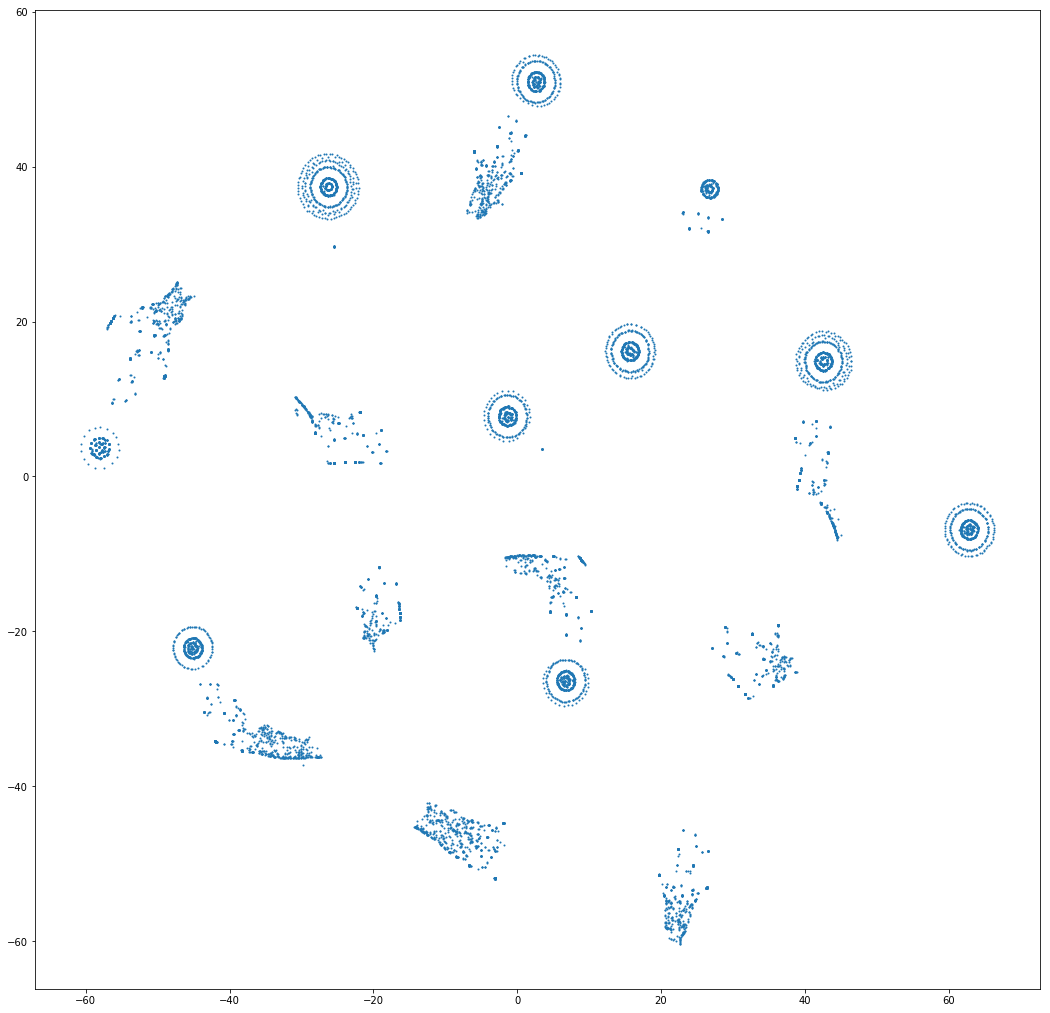

In [416]:
# print(y_agg[0:3])
# for i in range(3):
#     print(y_agg[i])
#     print(mn.entropy(1, y_agg[i]))
#     print('')

# take only images with nonzero entropy
y_agg_he = []
X_test_he = []
for i in range(y_agg.shape[0]):
    #if mn.entropy(1, y_agg[i]) != 0:
    y_agg_he.append(y_agg[i])
    X_test_he.append(X_test[i])
y_agg_he = np.array(y_agg_he)
print(y_agg_he.shape)
X_test_he = np.array(X_test_he)


embedding = manifold.TSNE(n_components=2, 
                          early_exaggeration=1.0,
                          random_state=1,
                          perplexity=100, # used to be 30
                          n_iter=3000, # used to be 1000
                          verbose=3).fit_transform(y_agg_he)

# MDS -- really odd results
# embedding_ = manifold.MDS(n_components=2, max_iter=300, eps=0.001, random_state=1,
#                    dissimilarity="euclidean", n_jobs=5, verbose=3).fit(y_agg_he).embedding_

# embedding = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=0.001,
#                     dissimilarity="euclidean", random_state=1, n_jobs=5, verbose=3,
#                     n_init=1).fit_transform(y_agg_he, init=embedding_)

print(embedding.shape)

X_to_plot = X_test_he

plt.figure(figsize=(18,18))
plt.scatter(embedding[:, 0], embedding[:, 1], s=1)

In [ ]:
fixed_embedding = embedding - embedding.min()
fixed_embedding = fixed_embedding / fixed_embedding.max()
x = fixed_embedding

N = X_to_plot.shape[0]
print(int(np.sqrt(N)), 'is max rows')
# break_it

S = 32*int(np.sqrt(N)) #32*60 # size of full embedding image
S = S - (S % 32)
print(S)
G = np.ones((S, S, 3,), dtype='uint8')*255
# print(G.shape)
s = 32; # size of every single image

used = []

qq = len(list(range(0, S, s))) # qq=len(range(1,s,S))
print(qq)
abes = np.zeros((qq**2, 2))

i = 0
for a in range(0, S, s):
    for b in range(0, S, s):
        abes[i,:] = [a, b]
        i += 1

for i in range(abes.shape[0]):
    a = abes[i, 0] # 0
    b = abes[i, 1] # 32
    xf = a / S     # 0.0
    yf = b / S     # 0.1
    
    dd = np.sum((x-[xf, yf])**2, axis=1) # (5607,)
    dd[used] = np.inf # dont pick these
    di = np.argmin(dd)
    used.append(di) # mark as done

    a, b = int(a), int(b)
    G[a:a+s, b:b+s, :] = X_to_plot[di]

plt.figure(figsize=(18,18))
plt.axis('off')
plt.imshow(G)

In [411]:
plt.figure(figsize=(18,18))
ax = plt.gca()

for im_idx in range(X_to_plot.shape[0]):
    imscatter(embedding[im_idx, 0], embedding[im_idx, 1], 
              X_to_plot[im_idx], ax=ax, zoom=0.75)
    # if im_idx == 1000: break
plt.axis('off')
plt.show()

(1600, 1600, 3)


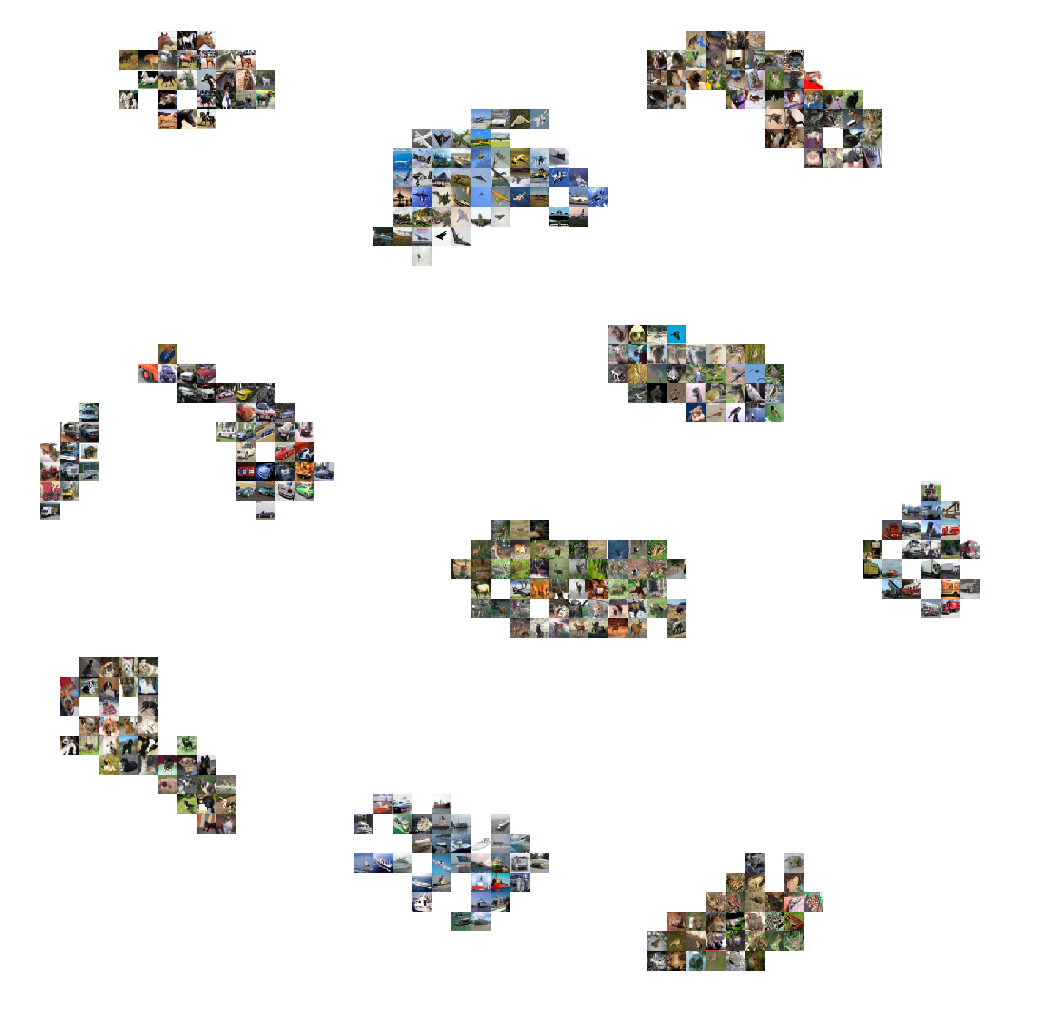

In [412]:
fixed_embedding = embedding - embedding.min()
fixed_embedding = fixed_embedding / fixed_embedding.max()

N = X_to_plot.shape[0]

S = 1600 # size of full embedding image
S = S - (S % 32)
G = np.ones((S, S, 3,), dtype='uint8')*255
print(G.shape)
s = 32; # size of every single image

Ntake = N
for i in range(Ntake):
        
    # location
    a = np.ceil(fixed_embedding[i, 0] * (S-s) + 1)
    b = np.ceil(fixed_embedding[i, 1] * (S-s) + 1)
    a = a - ((a-1) % s) + 1
    b = b - ((b-1) % s) + 1
    
    a, b = int(a), int(b)
    
    if G[a, b, 0] != 255:
        continue # spot already filled
    
#     I = imresize(I, [s, s]);
    try:
        G[a:a+s, b:b+s, :] = X_to_plot[i]
    except:
#         print(i)
        pass

plt.figure(figsize=(18,18))
plt.axis('off')
plt.imshow(G)

In [419]:
fixed_embedding = embedding - embedding.min()
fixed_embedding = fixed_embedding / fixed_embedding.max()
x = fixed_embedding

N = X_to_plot.shape[0]
print(int(np.sqrt(N)), 'is max rows')
# break_it

S = 32*int(np.sqrt(N)) #32*60 # size of full embedding image
S = S - (S % 32)
print(S)
G = np.ones((S, S, 3,), dtype='uint8')*255
# print(G.shape)
s = 32; # size of every single image

used = []

qq = len(list(range(0, S, s))) # qq=len(range(1,s,S))
print(qq)
abes = np.zeros((qq**2, 2))

i = 0
for a in range(0, S, s):
    for b in range(0, S, s):
        abes[i,:] = [a, b]
        i += 1

for i in range(abes.shape[0]):
    a = abes[i, 0] # 0
    b = abes[i, 1] # 32
    xf = a / S     # 0.0
    yf = b / S     # 0.1
    
    dd = np.sum((x-[xf, yf])**2, axis=1) # (5607,)
    dd[used] = np.inf # dont pick these
    di = np.argmin(dd)
    used.append(di) # mark as done

    a, b = int(a), int(b)
    G[a:a+s, b:b+s, :] = X_to_plot[di]

imsave('human_probs_embed_100x100.png', G)
plt.figure(figsize=(18,18))
plt.axis('off')
plt.imshow(G)

100 is max rows
3200
100


/home/joshuacp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
